In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D
from population import unit_response_matrix, pop_activity_phase_shifted
from matplotlib.lines import Line2D

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [17]:
# collecting SNR stats
SNR_stats = {}

In [35]:
SNR_stats['57'] = []

In [42]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

# 009266
sessions = [s for s in selected_009266.keys()]
sessions.sort()
selected = sessions[:]
selected.remove('009266_hippoSIT_2023-04-21_08-43-00')
selected.remove('009266_hippoSIT_2023-06-14_08-21-23')
selected.remove('009266_hippoSIT_2023-06-19_08-58-35')


# 009265
sessions = [s for s in selected_009265.keys()]
sessions.sort()
sessions.remove('009265_hippoSIT_2023-02-27_10-18-32')
sessions.remove('009265_hippoSIT_2023-02-27_15-33-46')
sessions = sessions[9:-2]
selected = selected + sessions

# animal 57
# selected = list(selected_57)
# selected.remove('57_SIT_2023-12-18_14-07-34')
# selected.remove('57_SIT_2023-12-29_11-06-26')
# selected.remove('57_SIT_2024-01-07_19-23-28')
#'57_SIT_2023-12-23_14-21-01'

# selected = [
#     "57_SIT_2023-12-22_14-08-07",
#     "57_SIT_2023-12-22_17-37-18",
#     "57_SIT_2023-12-28_16-43-28",
#     "57_SIT_2023-12-29_11-06-26",
#     "57_SIT_2023-12-29_11-40-14",
#     "57_SIT_2024-01-02_16-38-05",
#     "57_SIT_2024-01-02_17-10-09",
#     "57_SIT_2024-01-03_19-54-59",
# ]

# selected = [
#     '009265_hippoSIT_2023-03-09_20-03-08',
#     '009265_hippoSIT_2023-03-05_11-52-17'
# ]
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34']

## SNR between nMAP clusters

In [43]:
# select binning for target / backgound
binning_mPFC_AEP = {
    50:  [8, 25, 45, 85, 105],
    75:  [8, 25, 45, 105, 127],
    100: [8, 25, 45, 128, 155],
}

binning_mPFC_PCA = {
    50:  [8, 16, 65, 85],
    57:  [8, 16, 72, 92],
    75:  [8, 16, 90, 110],
    100: [8, 16, 115, 135],
}

binning_AC_AEP = {
    50:  [15, 28, 73, 100],
    90:  [15, 28, 107, 135],
    100: [15, 28, 118, 145],
    150: [15, 28, 168, 195],
}

# for the moment define binning scheme manually for each animal
all_binnings = {
    '009265': binning_AC_AEP,
    '009266': binning_AC_AEP,
    '57': binning_mPFC_PCA,
}

nMAP_electrodes = {
    '009265': [1, 2],
    '009266': [1, 2],
    '57': [1]
}

/tmp/ipykernel_1587512/1221382377.py:94: RuntimeWarning: invalid value encountered in true_divide
  snr[idxs_noi_zero] = ((np.abs(sig - noi) + noi)/noi)[idxs_noi_zero]


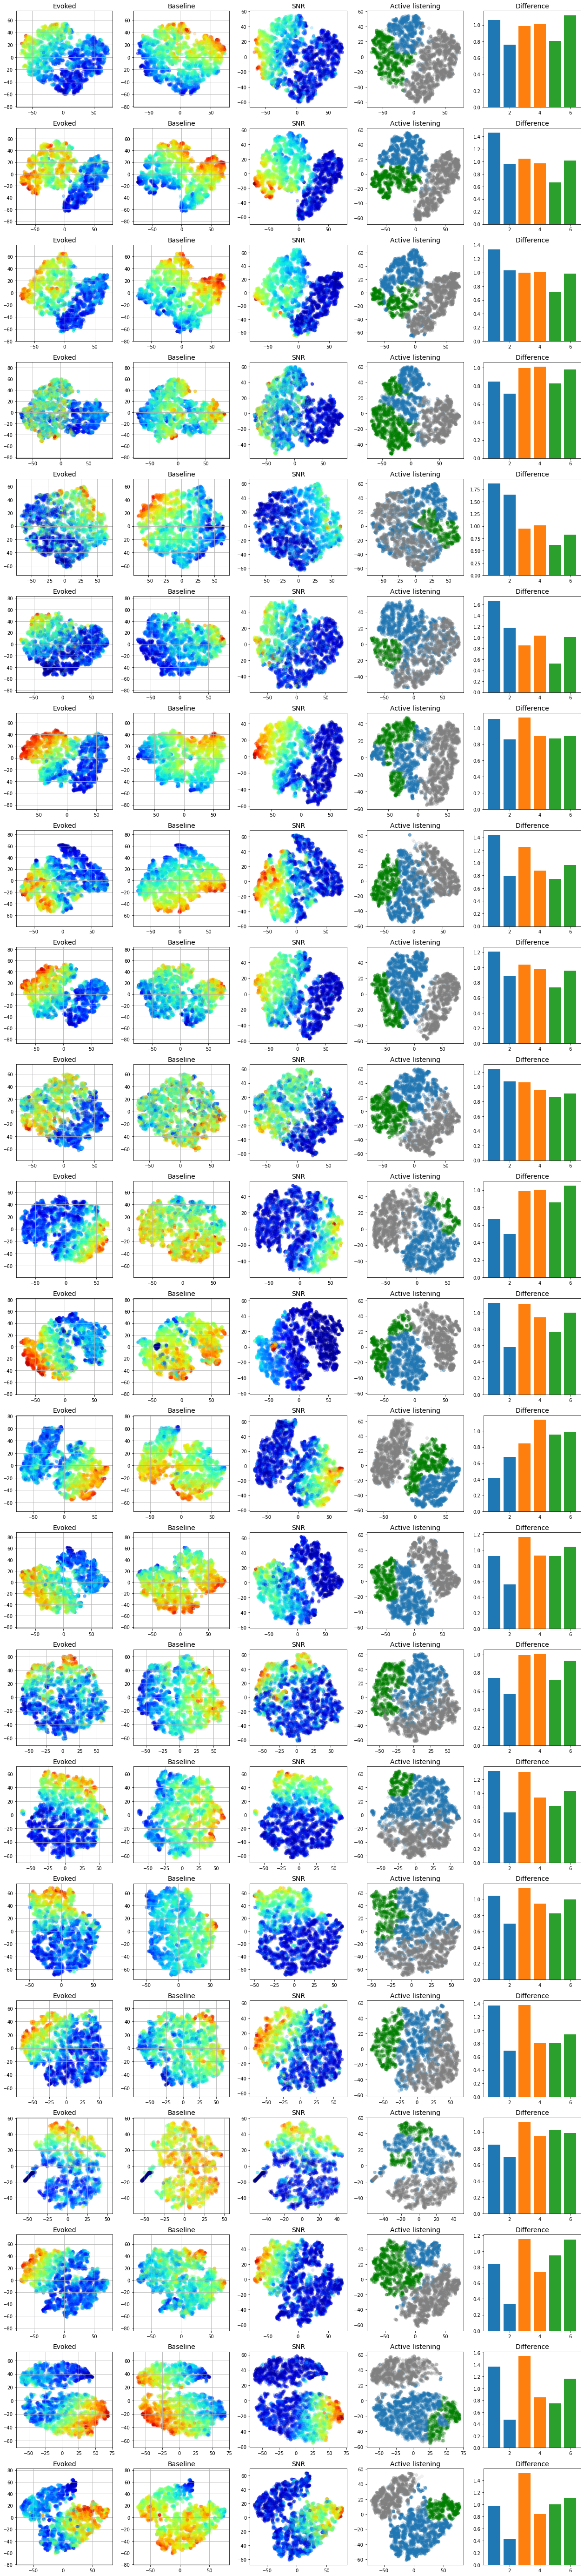

In [44]:
ft, fp = 'tSNE', 70
k_width = 30
rows = len(selected)
cols = 5
size = 3.5
fig, axes = plt.subplots(rows, cols, figsize=(cols*size, rows*size))
titles = ['Evoked', 'Baseline', 'SNR', 'Active listening', 'Difference']

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    if not animal in SNR_stats:
        SNR_stats[animal] = []

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    nMAP_seg_file = os.path.join(source, animal, session, 'analysis', 'nMAP_segmentation.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
        cfg = json.loads(f['processed'].attrs['parameters'])
    with h5py.File(umap_file, 'r') as f:
        n_fit = np.array(f[ft][str(fp)])
        extent = get_extent(n_fit, margin=5)
    with h5py.File(nMAP_seg_file, 'r') as f:
        d_map = np.array(f['density_map'])
        segmentation = np.array(f['segmentation'])
        segmentation_TGT_succ = np.array(f['segmentation_TGT_succ'])
        idxs_tgt_succ_state_ev = np.array(f['idxs_tgt_succ_state_ev'])
        tgt_stats = np.array(f['tgt_stats'])
        tgt_stats_shuf = np.array(f['tgt_stats_shuf'])
        
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]
    idxs_bgr_AL = np.intersect1d(idxs_bgr_ev, idxs_tgt_succ_state_ev)
    idxs_bgr_PH = np.array([x for x in idxs_bgr_ev if not x in idxs_tgt_succ_state_ev])
    
    # ------- compute SNR based on all E1-3 / S1  -----------

    # define actual binning for target / background
    dur_bgr = int(cfg['sound']['sounds']['background']['duration'] * 1000)  # in ms
    dur_tgt = int(cfg['sound']['sounds']['target']['duration'] * 1000)  # in ms

    selected_binning = all_binnings[animal] if animal in all_binnings else binning_AC_AEP
    bins_bgr = selected_binning[dur_bgr]
    bins_tgt = selected_binning[dur_tgt]
    
    assert dur_bgr in selected_binning
    assert dur_tgt in selected_binning
    
    # electrodes in A1
    electrodes = nMAP_electrodes[animal]

    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]

    bins, unit_mx_bgr = unit_response_matrix(s_path, electrodes, bins_bgr)
    bins, unit_mx_tgt = unit_response_matrix(s_path, electrodes, bins_tgt)

    w_mx = []
    kernel = signal.gaussian(k_width, std=(k_width) / 7.2)
    for phase in range(len(bins_bgr)):
        bins_bgr_e = bins_bgr + [250]
        bins_tgt_e = bins_tgt + [250]

        # normalize by window size (important when different between BGR and TGT)
        resp_at_phase_bgr = unit_mx_bgr[phase + 1::len(bins_bgr) + 1] / ((bins_bgr_e[phase + 1] - bins_bgr_e[phase]) / 1000)
        resp_at_phase_tgt = unit_mx_tgt[phase + 1::len(bins_tgt) + 1] / ((bins_tgt_e[phase + 1] - bins_tgt_e[phase]) / 1000)

        # let no stimulus and noise episodes be binned as background
        resp_at_phase = resp_at_phase_bgr.copy()
        resp_at_phase[idxs_tgt_ev] = resp_at_phase_tgt[idxs_tgt_ev]
        
        pop_act = resp_at_phase.mean(axis=1)  # or just a sum
        pop_act = np.convolve(pop_act, kernel, 'same') / kernel.sum()
        
        w_mx.append(pop_act)
        
    w_mx = np.column_stack(w_mx)
    
    noi = w_mx[:, 3]
    sig = w_mx[:, 0]
    sig1 = np.abs(w_mx[:, 0] - noi)
    sig2 = np.abs(w_mx[:, 1] - noi)
    sig3 = np.abs(w_mx[:, 2] - noi)
    
    snr = np.ones(len(w_mx))
    idxs_noi_zero = np.where(noi != 0)[0]
    snr[idxs_noi_zero] = ((np.abs(sig - noi) + noi)/noi)[idxs_noi_zero]
    #snr[idxs_noi_zero] = ((sig1 + sig2 + sig3 + noi)/noi)[idxs_noi_zero]
    
        
    # SNR based on pop activity (E1-3/S1) - wrong way?
#     w_mx = pop_activity_phase_shifted(s_path, selected_binning[dur_bgr], selected_binning[dur_tgt], electrodes=electrodes, do_pca=True)

#     sig = w_mx[:, 0]
#     noi = w_mx[:, 3]
    
#     snr = np.ones(len(w_mx))
#     idxs_noi_zero = np.where(noi != 0)[0]
#     snr[idxs_noi_zero] = ((np.abs(sig - noi) + noi)/noi)[idxs_noi_zero]
    
    # SNR based on E1 / S1
#     times_to_event = [15, 30]
#     bins, unit_mx = unit_response_matrix(s_path, electrodes, times_to_event=times_to_event)

#     sig = unit_mx[1::len(times_to_event) + 1].mean(axis=1) * (220/15) # norm by window size
#     noi = unit_mx[2::len(times_to_event) + 1].mean(axis=1)

#     k_width = 30
#     kernel = signal.gaussian(k_width, std=(k_width) / 7.2)
#     sig_sm = np.convolve(sig, kernel, 'same') / kernel.sum()
#     noi_sm = np.convolve(noi, kernel, 'same') / kernel.sum()

#     snr = np.ones(len(sig_sm))
#     idxs_noi_zero = np.where(noi != 0)[0]
#     snr[idxs_noi_zero] = ((np.abs(sig_sm - noi_sm) + noi_sm)/noi_sm)[idxs_noi_zero]

    # -------------------
    
    # scatters
    ax = axes[i][0]
    ax.scatter(n_fit[:, 0], n_fit[:, 1], alpha=0.1, cmap='jet', c=sig)
    ax = axes[i][1]
    ax.scatter(n_fit[:, 0], n_fit[:, 1], alpha=0.1, cmap='jet', c=noi)
    ax = axes[i][2]
    ax.scatter(n_fit[:, 0], n_fit[:, 1], alpha=0.1, cmap='jet', c=np.log(snr))

    
    # seleted areas by TGT
    ax = axes[i][3]
    #ax.imshow(segmentation_TGT_succ.T, origin='lower', extent=extent)
    ax.scatter(n_fit[idxs_bgr_AL][:, 0], n_fit[idxs_bgr_AL][:, 1], alpha=0.1, color='green')
    ax.scatter(n_fit[idxs_bgr_PH][:, 0], n_fit[idxs_bgr_PH][:, 1], alpha=0.1, color='tab:blue')
    ax.scatter(n_fit[idxs_sil_ev][:, 0], n_fit[idxs_sil_ev][:, 1], alpha=0.1, color='gray')
    
    for ax in axes[i][:2]:
        ax.grid()
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_aspect('equal')
        
    for j, ax in enumerate(axes[i]):
        ax.set_title(titles[j], fontsize=14)
    
    # E1, S1, SNR means
    E1_bgr = sig[idxs_bgr_ev].mean()
    S1_sil = noi[idxs_sil_ev].mean()
    SNR_AL, SNR_PH = np.log(snr)[idxs_bgr_AL].mean(), np.log(snr)[idxs_bgr_PH].mean()
    #SNR_AL, SNR_PH = snr[idxs_bgr_AL].mean(), snr[idxs_bgr_PH].mean()
    E1_AL, E1_PH   = sig[idxs_bgr_AL].mean()/E1_bgr, sig[idxs_bgr_PH].mean()/E1_bgr
    S1_AL, S1_PH   = noi[idxs_bgr_AL].mean()/S1_sil, noi[idxs_bgr_PH].mean()/S1_sil
    SNR_stats[animal] = SNR_stats[animal] + [
        (E1_PH, E1_AL),
        (S1_PH, S1_AL),
        (SNR_PH, SNR_AL)
    ]
    
    ax = axes[i][4]
    ax.bar([1, 2], [SNR_AL, SNR_PH])
    ax.bar([3, 4], [E1_AL, E1_PH])
    ax.bar([5, 6], [S1_AL, S1_PH])

fig.tight_layout()

In [43]:
fig.savefig(os.path.join(report, 'population', 'nMAP_SNR_%s_sel.png' % animal), dpi=300)

## Cross-animal

In [45]:
def get_asterisks(pval):
    if pval > 0.05:
        return 'n.s.'
    elif pval > 0.01:
        return '*'
    elif pval > 0.001:
        return '**'
    else:
        return '***'

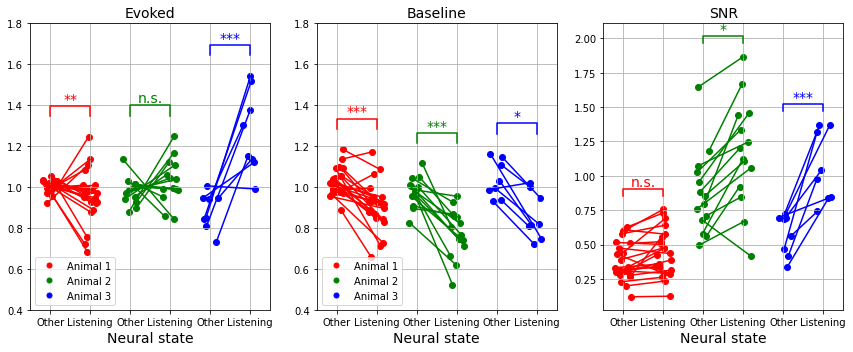

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

titles = ['Evoked', 'Baseline', 'SNR']
colors = ['red', 'green', 'blue']

animals = [k for k in SNR_stats.keys()]
n_data = len(animals)
for i, (animal, SNR_data) in enumerate(SNR_stats.items()):
    SNR_data_array = np.array(SNR_data)
    
    for j, ax in enumerate(axes):
        metric = SNR_data_array[j::3]
        x_vals_AL = (2*i + 1)*np.ones(len(metric)) + (np.random.rand(len(metric)) - 0.5)*0.4
        x_vals_PH = (2*i + 2)*np.ones(len(metric)) + (np.random.rand(len(metric)) - 0.5)*0.4
        ax.scatter(x_vals_AL, metric[:, 0], color=colors[i])
        ax.scatter(x_vals_PH, metric[:, 1], color=colors[i])
        for k, record in enumerate(metric):
            ax.plot([x_vals_AL[k], x_vals_PH[k]], [metric[k][0], metric[k][1]], color=colors[i])
            
        # stats
        _, pval = stats.mannwhitneyu(metric[:, 0], metric[:, 1])
        x1, x2 = 2*i + 1, 2*i + 2
        y, h = max(map(max, metric)) + 0.1, 0.05

        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=colors[i])
        ax.text((x1+x2)*.5, y+h, get_asterisks(pval), ha='center', va='bottom', color=colors[i], fontsize=14)
        
        

for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlim(0.5, n_data*2 + 0.5)
    if i < 2:
        ax.set_ylim(0.4, 1.8)
    ax.set_xticks(np.arange(2*n_data) + 1)
    ax.set_xticklabels(['Other', 'Listening', 'Other', 'Listening', 'Other', 'Listening'])
    ax.set_xlabel('Neural state', fontsize=14)
    ax.grid()
    
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color=colors[0], markersize=10, label='Animal 1'),
    Line2D([0], [0], marker='.', linestyle='None', color=colors[1], markersize=10, label='Animal 2'),
    Line2D([0], [0], marker='.', linestyle='None', color=colors[2], markersize=10, label='Animal 3')
]
axes[0].legend(handles=legend_elements, loc='lower left')
axes[1].legend(handles=legend_elements, loc='lower left')

fig.tight_layout()

In [49]:
fig.savefig(os.path.join(report, 'population', 'nMAP_E1_S1_SNR_%s_cross.png' % animal), dpi=300)

## On neural manifold

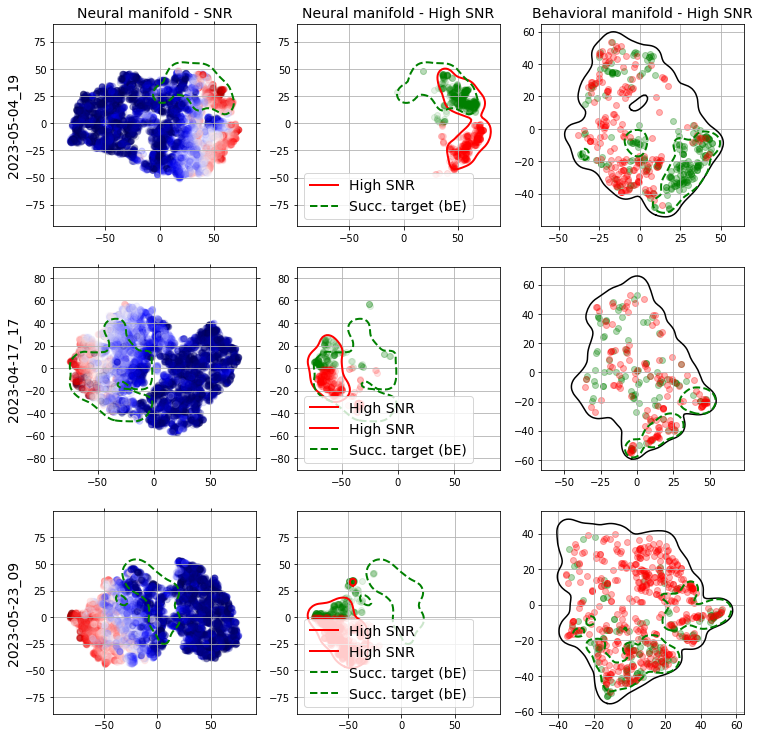

In [68]:
ft, fp = 'tSNE', 70
#ft, fp = 'UMAP', 0.5
rows = len(selected)
fig, axes = plt.subplots(rows, 3, figsize=(10.5, rows*3.5))
titles = ['Neural manifold - SNR', 'Neural manifold - High SNR', 'Behavioral manifold - High SNR']

for i, session in enumerate(selected):
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    state_file = os.path.join(source, animal, session, 'analysis', 'state_idxs.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(umap_file, 'r') as f:
        n_fit = np.array(f[ft][str(fp)])
    with h5py.File(state_file, 'r') as f:
        idxs_AL_ev = np.array(f['idxs_AL_ev'])  # bAL state
        idxs_neuro_AL_bgr_ev = np.array(f['idxs_neuro_AL_bgr_ev'])
        idxs_neuro_AL_sil_ev = np.array(f['idxs_neuro_AL_sil_ev'])
        idxs_neuro_PH_bgr_ev = np.array(f['idxs_neuro_PH_bgr_ev'])
        idxs_neuro_PH_sil_ev = np.array(f['idxs_neuro_PH_sil_ev'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        b_fit = np.array(f[ft][str(fp)])

    n_extent = get_extent(n_fit, margin=10)
    b_extent = get_extent(b_fit, margin=10)
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]

    idxs_srm_succ = []
    idxs_succ_ev = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        tl_l, tl_r = tgt_rec[2], tgt_rec[3]
        idxs_srm_succ += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
        idxs_succ_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_srm_succ = np.array(idxs_srm_succ)
    idxs_succ_ev = np.array(idxs_succ_ev)
    
    times_to_event = [15, 30]
    bins, unit_mx = unit_response_matrix(s_path, [1, 2], times_to_event=times_to_event)

    sig = unit_mx[1::len(times_to_event) + 1].mean(axis=1) * (220/15) # norm by window size
    noi = unit_mx[2::len(times_to_event) + 1].mean(axis=1)

    k_width = 30
    kernel = signal.gaussian(k_width, std=(k_width) / 7.2)
    sig_sm = np.convolve(sig, kernel, 'same') / kernel.sum()
    noi_sm = np.convolve(noi, kernel, 'same') / kernel.sum()

    snr = np.ones(len(sig_sm))
    idxs_noi_zero = np.where(noi != 0)[0]
    snr[idxs_noi_zero] = ((np.abs(sig_sm - noi_sm) + noi_sm)/noi_sm)[idxs_noi_zero]

    # just plot W4
    #snr = activity_at_phase(s_path, phase=4, do_pca=True, k_width=30)

    data = np.log(snr)
    if len(data) < len(fit):
        data = np.concatenate([data, [data[-1]]])
    snr_thresh = 0.6*np.log(snr).max()
    idxs_high_snr_ev  = np.where(np.log(snr) > snr_thresh)[0]
    idxs_high_snr_srm = np.where(np.log(snr[::2]) > snr_thresh)[0]
    idxs_pos_ev = np.where(n_fit[:, 1] > 0)[0]
    idxs_neg_ev = np.where(n_fit[:, 1] < 0)[0]
    idxs_pos_srm = np.where(n_fit[::2][:, 1] > 0)[0]
    idxs_neg_srm = np.where(n_fit[::2][:, 1] < 0)[0]
    
    idxs_pos_high_snr_ev = np.intersect1d(idxs_high_snr_ev, idxs_pos_ev)
    idxs_neg_high_snr_ev = np.intersect1d(idxs_high_snr_ev, idxs_neg_ev)
    idxs_pos_high_snr_srm = np.intersect1d(idxs_high_snr_srm, idxs_pos_srm)
    idxs_neg_high_snr_srm = np.intersect1d(idxs_high_snr_srm, idxs_neg_srm)

    # contours
    sigma = 0.3
    margin = 10
    
    # fit behav contours
    d_map  = density_map(b_fit, b_extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    CS_b_fit = axes[i][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=b_extent)
    
    # success TGT on behavioral manifold
    d_map   = density_map(b_fit[idxs_srm_succ], b_extent, sigma=sigma, bin_count=100)
    levels  = np.linspace(0.2*d_map.max(), d_map.max(), 2)
    CS_b_succ = axes[i][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=b_extent)
    
    # success TGT on neural manifold
    d_map  = density_map(n_fit[idxs_succ_ev], n_extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    CS_n_succ = axes[i][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=n_extent)

    # high SNR on neural manifold
    d_map  = density_map(n_fit[idxs_high_snr_ev], n_extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    CS_n_high_snr = axes[i][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=n_extent)

    axes[i][0].clear()  # clear axes from original contours
    
    # SNR
    n_size = n_extent[1] - n_extent[0]
    ax = axes[i][0]
    ax.scatter(n_fit[:, 0], n_fit[:, 1], alpha=0.1, cmap='seismic', c=data)
    ax.set_ylabel(session[-19:-6], fontsize=14)
    #ax.text(n_extent[0] + 0.05*n_size, n_extent[3] - 0.05*n_size, 'Neural manifold', fontsize=14)
    for path in CS_n_succ.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], ls='--', lw=2, color='green')
        
    # High SNR
    ax = axes[i][1]
    #ax.scatter(n_fit[idxs_high_snr_ev][:, 0], n_fit[idxs_high_snr_ev][:, 1], alpha=0.1, color='red')
    ax.scatter(n_fit[idxs_pos_high_snr_ev][:, 0], n_fit[idxs_pos_high_snr_ev][:, 1], alpha=0.1, color='green')
    ax.scatter(n_fit[idxs_neg_high_snr_ev][:, 0], n_fit[idxs_neg_high_snr_ev][:, 1], alpha=0.1, color='red')
    #ax.text(n_extent[0] + 0.05*n_size, n_extent[3] - 0.05*n_size, 'Neural manifold', fontsize=14)
    for path in CS_n_high_snr.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], lw=2, color='red', label='High SNR')
    for path in CS_n_succ.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], ls='--', lw=2, color='green', label='Succ. target (bE)')
    #legend_elements = [
    #    Line2D([0], [0], marker='_', linestyle='None', color='green', markersize=10, label='Succ. target (bE)'),
    #    Line2D([0], [0], marker='_', linestyle='None', color='red', markersize=10, label='High SNR')
    #]
    #ax.legend(handles=legend_elements, loc='lower left', fontsize=14)
    ax.legend(loc='lower left', fontsize=14)
    
    # High SNR on behavior
    b_size = b_extent[1] - b_extent[0]
    ax = axes[i][2]
    #ax.scatter(b_fit[:, 0], b_fit[:, 1], alpha=0.05, color='black')
    #ax.scatter(b_fit[idxs_high_snr_srm][:, 0], b_fit[idxs_high_snr_srm][:, 1], alpha=0.1, color='red')
    ax.scatter(b_fit[idxs_pos_high_snr_srm][:, 0], b_fit[idxs_pos_high_snr_srm][:, 1], alpha=0.3, color='green')
    ax.scatter(b_fit[idxs_neg_high_snr_srm][:, 0], b_fit[idxs_neg_high_snr_srm][:, 1], alpha=0.3, color='red')
    #ax.text(b_extent[0] + 0.05*b_size, b_extent[3] - 0.1*b_size, 'Behavioral manifold', fontsize=14)
    for path in CS_b_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='black')
    for path in CS_b_succ.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], lw=2, ls='--', color='green')
        
    extents = [n_extent, n_extent, b_extent]
    for j, ax in enumerate(axes[i]):
        extent = extents[j]
        ax.grid()
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.set_aspect('equal')
        if i == 0:
            ax.set_title(titles[j], fontsize=14)   

fig.tight_layout()

In [69]:
fig.savefig(os.path.join(report, 'showroom', 'high_SNR_%s_sample.png' % animal), dpi=500)